In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import HuberRegressor as hreg
from sklearn.model_selection import cross_validate

from scipy.interpolate import interp1d as spline

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
# tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging' #|FreqMorph_Decision|FreqMorph_Timeout|TwoTower_noTimeout|TwoTower_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]
regions = 'CA2|CA3|DG'
df = df[~df['ImagingRegion'].str.contains(regions,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5','4222168.1'] #,'4139266.3'] #,'4222175.0']
# morph_familiar = ['4222153.2','4222154.1','4222153.1','4222157.3','4222174.1','4222153.3']
morph_familiar = ['4222153.1','4222153.2','4222153.3','4222174.1','4222154.1']

In [4]:
def sess_lar(sess,max_pos=450,cellmask = None,first_trial=0):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    print(C.shape)
    S=S/1546
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


    effMorph = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter'] + trial_info['towerJitter']
    effMorph = (effMorph+.3)/1.6
    effMorph = effMorph[first_trial:]
    rewards = 1.*(trial_info['rewards']>0)
    rewards = rewards[first_trial:]

    msort = np.argsort(effMorph)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    S_trial_mat = S_trial_mat[first_trial:,:,:]
    posmask = centers<=max_pos
    S_tm = S_trial_mat[:,posmask,:].reshape([S_trial_mat.shape[0],-1])
    S_tm_norm = S_tm/np.linalg.norm(S_tm,ord=2,axis=1)[:,np.newaxis]
   # S_sm = np.matmul(S_tm_norm,S_tm_norm.T)


    lar = np.zeros(effMorph.shape)
    sim0 = np.zeros(effMorph.shape)
    sim1 = np.zeros(effMorph.shape)
    for trial in range(effMorph.shape[0]):
        mask0 = trial_info['morphs'][first_trial:]==0
        mask1 = trial_info['morphs'][first_trial:]==1
        if trial_info['morphs'][trial+first_trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial+first_trial]==1:
            mask1[trial]=False
            
        centroid0, centroid1 = np.nanmean(S_tm[mask0,:],axis=0), np.nanmean(S_tm[mask1,:],axis=0)
        
        centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
        centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
#         cd = centroid0-centroid1
#         cd/=np.linalg.norm(cd.ravel(),ord=2)
        
        angle0, angle1 = np.dot(S_tm_norm[trial,:],centroid0), np.dot(S_tm_norm[trial,:],centroid1) 
        sim0[trial],sim1[trial] = angle0,angle1
#         print(effMorph[trial],sim0[trial],sim1[trial])
#         lar[trial]= np.log(np.dot(S_tm_norm[trial,:],centroid0)/np.dot(S_tm_norm[trial,:],centroid1))
#         lar[trial] = np.dot(S_tm_norm[trial,:],cd)
        lar[trial]=angle0/(angle0+angle1)
        
    return lar, effMorph, sim0, sim1
        

    

In [5]:
mouse = '4139265.4'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1371,4139265.4,07_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1373,4139265.4,07_02_2019,4,TwoTower_foraging,60,1,CA1,2019-02-07,G:\My Drive\VR_Data\TwoTower\4139265.4\07_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\07_02_2...
1407,4139265.4,10_02_2019,2,TwoTower_foraging,60,1,CA1,2019-02-10,G:\My Drive\VR_Data\TwoTower\4139265.4\10_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\10_02_2...
1436,4139265.4,12_02_2019,2,TwoTower_foraging,85,1,CA1,2019-02-12,G:\My Drive\VR_Data\TwoTower\4139265.4\12_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\12_02_2...
1459,4139265.4,15_02_2019,3,TwoTower_foraging,82,1,CA1,2019-02-15,G:\My Drive\VR_Data\TwoTower\4139265.4\15_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\15_02_2...
1478,4139265.4,17_02_2019,2,TwoTower_foraging,94,1,CA1,2019-02-17,G:\My Drive\VR_Data\TwoTower\4139265.4\17_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\17_02_2...
1489,4139265.4,18_02_2019,2,TwoTower_foraging,101,1,CA1,2019-02-18,G:\My Drive\VR_Data\TwoTower\4139265.4\18_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\18_02_2...
1498,4139265.4,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,G:\My Drive\VR_Data\TwoTower\4139265.4\19_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\19_02_2...
1510,4139265.4,20_02_2019,2,TwoTower_foraging,99,1,CA1,2019-02-20,G:\My Drive\VR_Data\TwoTower\4139265.4\20_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\20_02_2...
1516,4139265.4,21_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-21,G:\My Drive\VR_Data\TwoTower\4139265.4\21_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...,G:\My Drive\2P_Data\TwoTower\4139265.4\21_02_2...


In [6]:
sess = df_mouse.iloc[-2]
lar, effMorph, sim0, sim1 = sess_lar(sess)

# VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
# trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)


num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
(100982,) (100982, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(30493, 1498)


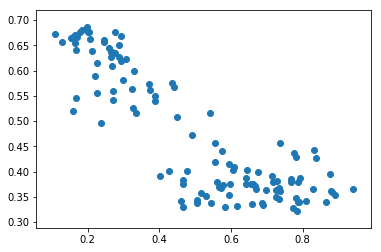

In [7]:
f,ax = plt.subplots()
ax.scatter(effMorph,lar)

In [8]:
def LAR_list_maker(mlist,firstSess = None,max_pos=450.):
    LAR, EM,S0,S1 = {},{},{},{}
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mlist,firstSess): 
        LAR[mouse],EM[mouse],S0[mouse],S1[mouse] = [],[],[],[]
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
#             print(sess)
            lar, em,s0,s1 = sess_lar(sess,max_pos=max_pos)
            LAR[mouse].append(lar)
            EM[mouse].append(em)
            S0[mouse].append(s0)
            S1[mouse].append(s1)
    return LAR, EM,S0,S1

In [9]:
LAR_rare,EM_rare,S0_rare,S1_rare = LAR_list_maker(morph_rare,firstSess=[5,5,5,3])

session ind 5
num aberrant ttls 0.0
35085 (35085,) (35085, 21) 115307
(115307,) (115307, 21)
frame diff 0
(35085, 1828)
session ind 6
num aberrant ttls 0.0
33140 (33140,) (33140, 21) 109003
(109003,) (109003, 21)
frame diff 0
(33140, 1904)
session ind 7
num aberrant ttls 0.0
38209 (38209,) (38209, 21) 126969
(126969,) (126969, 21)
frame diff 0
(38209, 1817)
session ind 8
num aberrant ttls 0.0
33547 (33547,) (33547, 21) 110218
(110218,) (110218, 21)
frame diff 0
(33547, 1708)
session ind 9
num aberrant ttls 0.0
32038 (32038,) (32038, 21) 105022
(105022,) (105022, 21)
frame diff 0
(32038, 1715)
session ind 5
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
(102093,) (102093, 21)
frame diff 0
(30897, 1632)
session ind 6
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
(95160,) (95160, 21)
frame diff 0
(29023, 1656)
session ind 7
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
(102131,) (102131, 21)
frame diff 0
(31116, 1515)
session ind 8
num aberrant ttls 0.0
31932 (

In [10]:
LAR_fam,EM_fam,S0_fam,S1_fam = LAR_list_maker(morph_familiar,firstSess=4)

session ind 4
num aberrant ttls 0.0
36036 (36036,) (36036, 21) 118455
(118455,) (118455, 21)
frame diff 0
(36036, 301)
session ind 5
num aberrant ttls 0.0
33778 (33778,) (33778, 21) 111444
(111444,) (111444, 21)
frame diff 0
(33778, 273)
session ind 6
num aberrant ttls 0.0
35977 (35977,) (35977, 21) 118959
(118959,) (118959, 21)
frame diff 0
(35977, 237)
session ind 4
num aberrant ttls 0.0
35248 (35248,) (35248, 21) 116195
(116195,) (116195, 21)
frame diff 0
(35248, 2127)
session ind 5
num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243
(121243,) (121243, 21)
frame diff 0
(33545, 2149)
session ind 6
num aberrant ttls 0.0
38697 (38697,) (38697, 21) 129389
(129389,) (129389, 21)
frame diff 0
(38697, 2046)
session ind 7
num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463
(121463,) (121463, 21)
frame diff 0
(37344, 1951)
session ind 4
num aberrant ttls 0.0
22769 (22769,) (22769, 21) 72892
(72892,) (72892, 21)
frame diff 0
(22769, 161)
session ind 4
num aberrant ttls 0.0
29526 (2952

In [11]:

def plot_LAR(LAR,EM,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR.keys())
    bins = np.linspace(ymin,ymax)
    print(N)
    for i,mouse in enumerate(LAR.keys()):
        if len(LAR[mouse])>0:
            print(mouse)
            lar,em = np.concatenate(LAR[mouse]),np.concatenate(EM[mouse])
#             lar/=np.amax(lar)-np.amin(lar)
#             lar-=lar.mean()
#             lar/=np.amax(np.abs(lar))
            print(lar.shape)
            ax_scat.scatter(em,lar,color=cmap(np.float(i/N)),alpha=.4,s=8)
            hist,edges = np.histogram(lar,bins=bins)
            ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
#             ax_hist.hist(lar,bins=50,orientation='horizontal',color=cmap(np.float(i/N)),alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

In [12]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\"

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)
5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(90,)
4222174.1
(400,)
4222154.1
(510,)


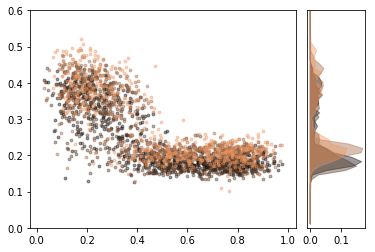

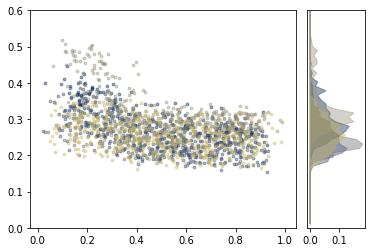

In [13]:
f,ax = plot_LAR(S0_rare,EM_rare,ymin=0,ymax=0.6)
# f.savefig(os.path.join(basedir,'rare_sim0.pdf'),format='pdf')

f,ax = plot_LAR(S0_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'fam_sim0.pdf'),format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)
5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(90,)
4222174.1
(400,)
4222154.1
(510,)


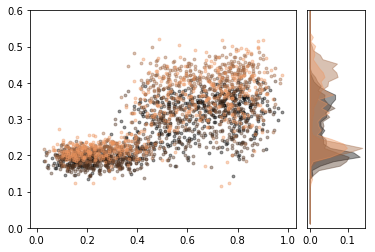

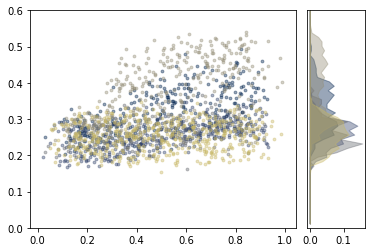

In [14]:
f,ax = plot_LAR(S1_rare,EM_rare,ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'rare_sim1.pdf'),format='pdf')
f,ax = plot_LAR(S1_fam,EM_fam,cmap='cividis',ymin=0,ymax=.6)
# f.savefig(os.path.join(basedir,'fam_sim1.pdf'),format='pdf')

4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)


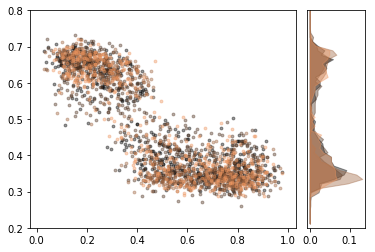

In [15]:
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper',ymin=.2,ymax=.8)
# f.savefig(os.path.join(basedir,'rare_simratio.pdf'),format='pdf')

5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(90,)
4222174.1
(400,)
4222154.1
(510,)


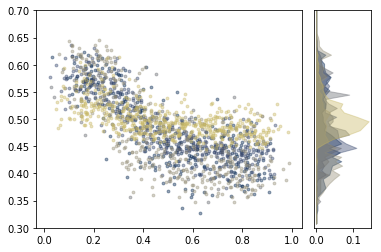

In [16]:

f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis',ymin=.3,ymax=.7)
# f.savefig(os.path.join(basedir,'fam_simratio.pdf'),format='pdf')

In [25]:

def mega_lar(LAR,exclude=()):
    mega_lar =  []
    for k,v in LAR.items():
        if k not in exclude:
            mega_lar.extend(v)
   
    return np.concatenate(mega_lar)


mega_lar_fam = mega_lar(LAR_fam)
mega_lar_rare = mega_lar(LAR_rare)

mega_em_fam = mega_lar(EM_fam)
mega_em_rare = mega_lar(EM_rare)

mega_s0_fam = mega_lar(S0_fam)
mega_s1_fam = mega_lar(S1_fam)

mega_s0_rare = mega_lar(S0_rare)
mega_s1_rare = mega_lar(S1_rare)



In [26]:
def make_ds_mask(_em):
    edges = np.array([-.3,.125,.375,.625,.875,1.3])
    hist,edges = np.histogram(_em,edges)
    med_f = np.median(hist)
    print(hist)
    print(edges)
    print(med_f)
    em_dig = np.digitize(_em,edges)
    print(np.unique(em_dig))

    ds_mask = np.ones(_em.shape)>0
    for i,b in enumerate(np.unique(em_dig).tolist()):
        inds = np.where(em_dig==b)[0]
    #     print(inds)
        if inds.shape[0]>med_f:
            to_pop = np.random.permutation(inds.shape[0])
            to_pop = to_pop[:int(inds.shape[0]-med_f)]
            ds_mask[to_pop]=False
    return ds_mask

In [19]:
# normalize
mega_em_rare_n = mega_em_rare*1.6 -.3
mega_em_fam_n = mega_em_fam*1.6 -.3

# downsample rare case

ds_mask = make_ds_mask(mega_em_rare_n)
        
mega_em_rare_n_ds, mega_lar_rare_ds = mega_em_rare_n[ds_mask],mega_lar_rare[ds_mask]
        
    



[591 413 412 406 588]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
413.0
[1 2 3 4 5]


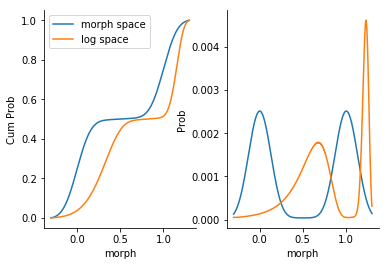

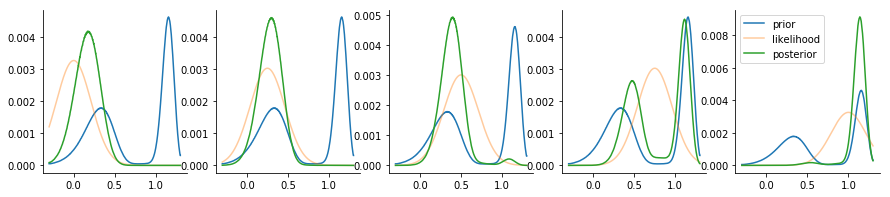

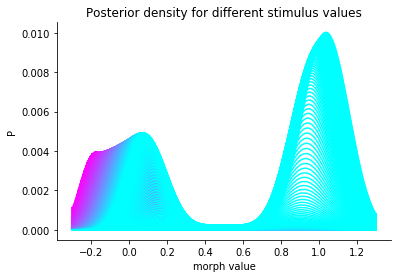

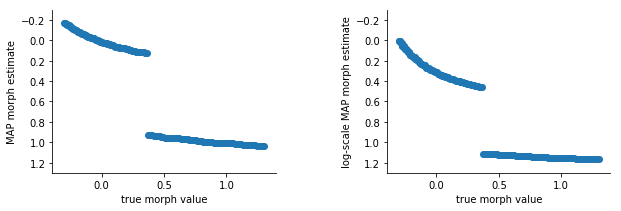

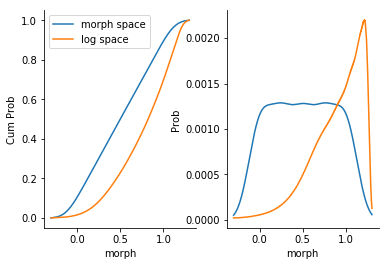

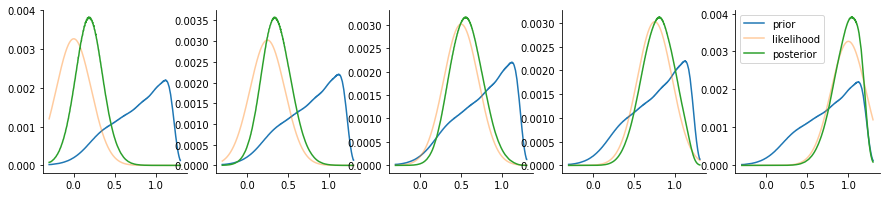

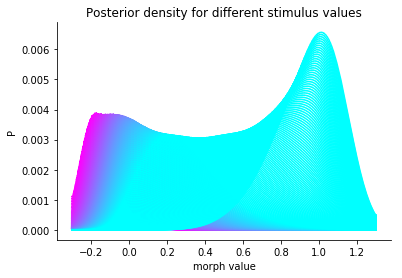

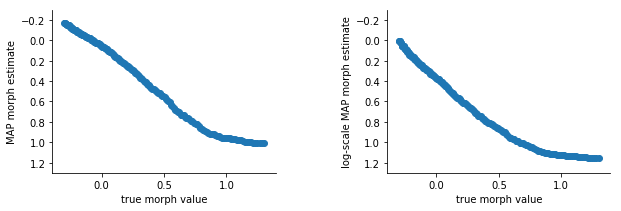

In [27]:
theta = np.linspace(-.1,1.1,num=200) # possible morph values
f1,f2 = .2,.8 # light dark 

mm = np.log(f1*(1-theta) + f2*(theta)) # log of the linear combinations of the stimuli
f1,f2 = 3,12 # actual frequencies the mouse sees
mm = (mm+ np.log(f1*(1-theta) + f2*(theta)))/2 # log of the linear combinations of the stimuli

# scale this so it's back in the range of the morph values without distortion
theta_corrected = (mm-np.amin(mm))/(np.amax(mm)-np.amin(mm))*1.6 - .3 
theta_corrected[0],theta_corrected[-1]=-.3,1.3 # hard code the edges to correct float errors
theta = np.linspace(-.3,1.3,num=200)

# splines for going between the two spaces
morph_2_logstim = spline(theta,theta_corrected)
logstim_2_morph = spline(theta_corrected,theta)

gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
unif = lambda mu, sigma, x: 1*(np.abs(x-mu)<=sigma/2)
def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()


def run_posterior_inference(p_theta,samp=np.linspace(-.3,1.3,num=1000)):
    '''function runs probabilistic inference and makes a few helpful plots
    Inputs: p_theta - the stimulus prior in log-space sampled at the values of previously defined theta
    Returns: figure and axes handles'''
    
    samp_mask = (samp>=-.3) & (samp<=1.3)
    ### RUN SOME DEMOS OF WHAT THE INFERENCE PROCESS LOOKS LIKE AT DIFFERENT STIMULUS VALUES
    
    # likelihood - zero centered gaussian with fixed variance in log space
    p_s_theta = gaussian_dens(0,.3,samp)

    # posterior - multiply likelihood and posterior and normalize to be a valid distribution
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(1,5,figsize=[15,3])
    ax_post_demo[0].plot(samp,p_theta,label='prior')
    ax_post_demo[0].plot(samp,p_s_theta,label='likelihood',alpha=.4)
    ax_post_demo[0].plot(samp,p_theta_s,label='posterior')
    
    ax_post_demo[0].spines['right'].set_visible(False)
    ax_post_demo[0].spines['top'].set_visible(False)
#     ax_post_demo[0].set_ylim([0,.05])
    # repeat above for a few other stimulus values
    for i,s in enumerate([.25,.5,.75,1]):
        # likelihood 
        p_s_theta = gaussian_dens(s,.3,samp)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)


        ax_post_demo[i+1].plot(samp[samp_mask],p_theta[samp_mask],label='prior')
        ax_post_demo[i+1].plot(samp[samp_mask],p_s_theta[samp_mask],label='likelihood',alpha=.4)
        ax_post_demo[i+1].plot(samp[samp_mask],p_theta_s[samp_mask],label='posterior')
        ax_post_demo[i+1].spines['right'].set_visible(False)
        ax_post_demo[i+1].spines['top'].set_visible(False)
#         ax_post_demo[i+1].set_ylim([0,.05])

    ax_post_demo[-1].legend()
    ### CALCULATE POSTERIOR AT RANGE OF STIMULUS VALUES AND PLOT
        
    f_post_dens,ax_post_dens = plt.subplots()
    ax_post_dens.spines['right'].set_visible(False)
    ax_post_dens.spines['top'].set_visible(False)
    theta_hat=[] # keep track of MAP estimate
    p_shat = [] # posterior at current value of stimulus
   
    for i,s in enumerate(theta): # sample log-spaced values
        p_s_theta = gaussian_dens(s,.3,samp) # likelihood
        p_theta_s = mult_and_norm(p_s_theta,p_theta) # posterior
        
        
        ax_post_dens.plot(logstim_2_morph(samp),p_theta_s,color=plt.cm.cool(1-i/100.)) # convert back from logspace
        theta_hat.append(samp[np.argmax(p_theta_s)]) # MAP estimate
#         theta_hat.append(p_theta_s[np.argmin(np.abs(samp))]*100.)
        p_shat.append((p_s_theta*p_theta).sum())

    ax_post_dens.set_ylabel('P')
    ax_post_dens.set_xlabel('morph value')
    ax_post_dens.set_title('Posterior density for different stimulus values')

    ## PLOT MAP ESTIMATE
    f_MAP,ax_MAP = plt.subplots(1,2,figsize=[10,3])
    f_MAP.subplots_adjust(wspace=.5)
    ax_MAP[0].spines['right'].set_visible(False)
    ax_MAP[0].spines['top'].set_visible(False)
    ax_MAP[0].scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)))
    ax_MAP[0].set_ylim([1.3,-.3])
    ax_MAP[0].set_ylabel('MAP morph estimate')
    ax_MAP[0].set_xlabel('true morph value')
    
    ax_MAP[1].spines['right'].set_visible(False)
    ax_MAP[1].spines['top'].set_visible(False)
    ax_MAP[1].scatter(logstim_2_morph(theta),np.array(theta_hat))
    ax_MAP[1].set_ylim([1.3,-.3])
    ax_MAP[1].set_ylabel('log-scale MAP morph estimate')
    ax_MAP[1].set_xlabel('true morph value')
    
    return np.array(theta_hat),(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP)


def convert_prior_to_log(prior,samp = np.linspace(-.3,1.3,num=1000)):
    '''convert a prior distribution in stimulus space to logspace for proper sampling
    Input: prior - arbitrary distribution assumed to be sampled in the range of values of theta variable
    Returns: log_dens - log space density for use with run_posterior_inference
             log_sampling_spline - log space cummulative distribution spline for sampling with kWTA_network_model (defined below)'''
    samp_mask = (samp>=-.3) & (samp<=1.3)
    # normalize to ensure prior is a proper distribution
    prior = np.convolve(prior,gaussian(.5,.1,samp),mode='same')
    prior/=prior.sum()
    # go to cummulative distribution so that conversion maintains density
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1 # correct for float errors
    cum_spline = spline(samp,cum_prior) # fit a linear interpolation spline so that we can arbitrarily sample
    log_cum_spline = spline(morph_2_logstim(samp),cum_prior)
    log_cum = log_cum_spline(samp) # sample cummulative distribution in log space
    log_sampling_spline = spline(cum_prior,morph_2_logstim(samp))  # create transposed spline for sampling values according to their probability
    
    f,ax = plt.subplots(1,2)
    
    
    for a in range(2):
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        
    ax[0].plot(samp[samp_mask],cum_prior[samp_mask],label='morph space')
    ax[0].plot(morph_2_logstim(samp[samp_mask]),cum_prior[samp_mask],label='log space')
    ax[0].legend()
    ax[0].set_ylabel('Cum Prob')
    ax[0].set_xlabel('morph')
    
    ax[1].plot(samp[samp_mask],prior[samp_mask])
    #convert cumulative density back to density
    log_dens = log_cum[1:]-log_cum[:-1]
    log_dens[:10]= log_dens[10] # stretching at the end of the spline causes artifacts so we're just clamping those values 
    log_dens = np.append(log_dens,log_dens[-1])
    log_dens /=log_dens.sum()
    ax[1].plot(morph_2_logstim(samp[samp_mask]),log_dens[samp_mask])
    ax[1].set_ylabel('Prob')
    ax[1].set_xlabel('morph')
#     ax[1].set_ylim([0,.05])
    
    return log_dens, log_sampling_spline

samp = np.linspace(-.3,1.3,num=1000)
# rare_prior = np.zeros(samp.shape)+.001
# rare_prior = gaussian(0,.2,samp)+gaussian(1,.2,samp)
# rare_prior /= rare_prior.sum()
dens = unif(0,.2,samp)+unif(1,.2,samp)+1E-2
f = unif(.5,.2,samp)
rare_prior = np.convolve(np.convolve(dens,f,mode='same'),f,mode='same')
rare_prior /= rare_prior.sum()


rare_log_dens, rare_lcs = convert_prior_to_log(rare_prior)

rare_p_shat, (f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(rare_log_dens)


# fam_prior = np.ones(samp.shape)#+.2
# # fam_prior/=1000
# fam_prior-=gaussian(-.3,.2,samp)
# fam_prior-=gaussian(1.3,.2,samp)
# fam_prior/=fam_prior.sum()
dens = unif(0,.2,samp)+unif(.25,.2,samp) + unif(.5,.2,samp) + unif(.75,.2,samp) + unif(1,.2,samp)+1E-2
f = unif(.5,.2,samp)
fam_prior = np.convolve(np.convolve(dens,f,mode='same'),f,mode='same')
# fam_prior = np.convolve(fam_prior,gaussian(.5,.2,samp),mode='same')
fam_prior =fam_prior/fam_prior.sum()



# fam_prior = np.zeros(samp.shape)
# for m in [0,.25,.5,.75,1.]:
#     fam_prior+=gaussian(m,.2,samp)
# fam_prior/=fam_prior.sum()


fam_log_dens, fam_lcs = convert_prior_to_log(fam_prior)

fam_p_shat,(f_post_demo,ax_post_demo),(f_post_dens,ax_post_dens),(f_MAP,ax_MAP) = run_posterior_inference(fam_log_dens)


In [28]:
import sklearn
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit, least_squares

def sigmoid(x,p):
#     print(p)
    x0,y0,c,k=p[0],p[1],p[2],p[3]
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y

def residuals(p,x,y):
    return y - sigmoid(x,p)


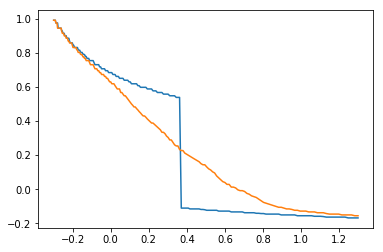

In [29]:
##
rare_map_spline = spline(logstim_2_morph(theta),rare_p_shat)
fam_map_spline = spline(logstim_2_morph(theta),fam_p_shat)
f,ax = plt.subplots()
ax.plot(logstim_2_morph(theta),1-rare_map_spline(logstim_2_morph(theta)))
ax.plot(logstim_2_morph(theta),1-fam_map_spline(logstim_2_morph(theta)))



# mega_em_rare_n = (mega_em_rare-mega_em_rare.min())/(mega_em_rare.max()-mega_em_rare.min())*1.6 -.3
# mega_em_fam_n = (mega_em_fam-mega_em_fam.min())/(mega_em_fam.max()-mega_em_fam.min())*1.6 -.3
# mega_em_rare_n = mega_em_rare*1.6 -.3
# mega_em_fam_n = mega_em_fam*1.6 -.3



rare_reg = hreg()
rare_reg.fit(rare_map_spline(mega_em_rare_n_ds[:,np.newaxis]),mega_lar_rare_ds)

rare_freg = linreg()
rare_freg.fit(fam_map_spline(mega_em_rare_n_ds[:,np.newaxis]),mega_lar_rare_ds)

rare_linreg = linreg()
rare_linreg.fit(mega_em_rare_n_ds[:,np.newaxis],mega_lar_rare_ds)

rare_sigres = least_squares(residuals,np.random.rand(4),args=(mega_em_rare_n_ds,mega_lar_rare_ds),loss='huber')
#rare_sig_popt, pcov =curve_fit(sigmoid,mega_em_rare_n,mega_lar_rare) #,p0 = np.random.rand(4))
#rare_sig = sigmoid(mega_em_rare_n,*rare_sig_popt)
    


    

fam_reg = linreg()
fam_reg.fit(fam_map_spline(mega_em_fam_n[:,np.newaxis]),mega_lar_fam)

fam_rreg = linreg()
fam_rreg.fit(rare_map_spline(mega_em_fam_n[:,np.newaxis]),mega_lar_fam)

fam_linreg = linreg()
fam_linreg.fit(mega_em_fam_n[:,np.newaxis],mega_lar_fam)

fam_sigres = least_squares(residuals,np.random.rand(4),args=(mega_em_fam_n,mega_lar_fam),loss='huber')
# fam_sig_popt, pcov = curve_fit(sigmoid,mega_em_fam_n,mega_lar_fam)



In [75]:
def model_comparison(em,lar):
    
    loo = sklearn.model_selection.LeaveOneOut()
    r_yhat,f_yhat,l_yhat,sig_yhat = np.zeros(em.shape),np.zeros(em.shape),np.zeros(em.shape),np.zeros(em.shape)
    for i,(_train,_test) in enumerate(loo.split(em)):
        r_reg  = hreg()
        r_reg.fit(rare_map_spline(em[_train,np.newaxis]),lar[_train])
        r_yhat[i]=r_reg.predict(rare_map_spline(em[_test,np.newaxis]))#-lar[_test])
    
        f_reg  = hreg()
        f_reg.fit(fam_map_spline(em[_train,np.newaxis]),lar[_train])
        f_yhat[i] =f_reg.predict(fam_map_spline(em[_test,np.newaxis]))#-lar[_test])
        
        l_reg  = hreg()
        l_reg.fit(em[_train,np.newaxis],lar[_train])
        l_yhat[i]=l_reg.predict(em[_test,np.newaxis])#-lar[_test])
        
        
        s_reg = least_squares(residuals,np.random.rand(4),args=(em[_train],lar[_train]),loss='huber')
        sig_yhat[i]=sigmoid(em[_test],s_reg.x)
#         popt, pcov = curve_fit(sigmoid,em[_train],lar[_train])
#         sig_yhat[i] = sigmoid(em[_test],*popt)
   
    return r_yhat, f_yhat, l_yhat,sig_yhat



def model_rss(em,lar):
    r_,f_,l_,s_ = model_comparison(em,lar)
    r2 = lambda y_: np.mean((y_-lar)**2)
    return r2(r_),r2(f_),r2(l_),r2(s_)



In [76]:
rare_cv = model_comparison(mega_em_rare_n_ds,mega_lar_rare_ds)
fam_cv = model_comparison(mega_em_fam_n,mega_lar_fam)

0.2511870845204179 1.4228558866977997e-58


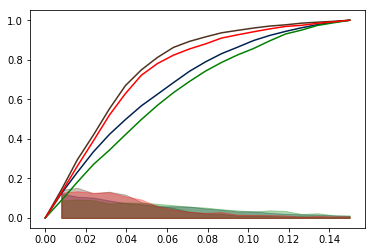

In [87]:
f,ax = plt.subplots()
edges = np.linspace(0,.15,num=20)
colors  = [plt.cm.copper(.25),plt.cm.cividis(0.),'green','red']
for i in range(4):
    res = np.abs(rare_cv[i]-mega_lar_rare_ds)
    hist,trsh = np.histogram(res,bins=edges)
#     ax.fill_between(edges[1:],hist/hist.sum(),color=colors[i],alpha=.3)
    cdf = np.cumsum(hist/hist.sum())
    ax.plot(edges[:],np.append(0,cdf),color=colors[i])

D,p = sp.stats.ks_2samp(np.abs(rare_cv[0]-mega_lar_rare_ds),np.abs(rare_cv[2]-mega_lar_rare_ds))
print(D,p)

0.03282532239155922 0.31206820282550374


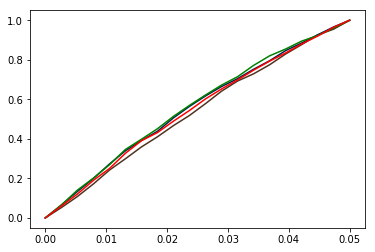

In [96]:
f,ax = plt.subplots()
edges = np.linspace(0,.05,num=20)
colors  = [plt.cm.copper(.25),plt.cm.cividis(0.),'green','red']
for i in range(4):
    res = np.abs(fam_cv[i]-mega_lar_fam)
    hist,trsh = np.histogram(res,bins=edges)
#     ax.fill_between(edges[1:],hist/hist.sum(),color=colors[i],alpha=.3)
    cdf = np.cumsum(hist/hist.sum())
    ax.plot(edges[:],np.append(0,cdf),color=colors[i])

D,p = sp.stats.ks_2samp(np.abs(fam_cv[1]-mega_lar_fam),np.abs(fam_cv[2]-mega_lar_fam))
print(D,p)

In [206]:
print('rare morph r2:', 1-((mega_lar_rare_ds-rare_cv[0])**2).mean()/np.var(mega_lar_rare_ds))

print('fam morph r2:', 1-((mega_lar_fam-fam_cv[1])**2).mean()/np.var(mega_lar_fam))


print('rare morph, freq fit r2:' , 1-((mega_lar_rare_ds-rare_cv[1])**2).mean()/np.var(mega_lar_rare_ds))

print('freq morph, rare fit r2:' , 1-((mega_lar_fam-fam_cv[0])**2).mean()/np.var(mega_lar_fam))


print('rare morph, linear fit r2:', 1-((mega_lar_rare_ds-rare_cv[2])**2).mean()/np.var(mega_lar_rare_ds))
print('freq morph, linear fit r2:' , 1-((mega_lar_fam-fam_cv[2])**2).mean()/np.var(mega_lar_fam))

print('rare morph, sigmoid fit r2:', 1-((mega_lar_rare_ds-rare_cv[3])**2).mean()/np.var(mega_lar_rare_ds))
print('freq morph, sigmoid fit r2:' , 1-((mega_lar_fam-fam_cv[3])**2).mean()/np.var(mega_lar_fam))


rare morph r2: 0.811989761476338
fam morph r2: 0.5336818824094686
rare morph, freq fit r2: 0.7891269317640284
freq morph, rare fit r2: 0.4895899282070504
rare morph, linear fit r2: 0.7276692601260302
freq morph, linear fit r2: 0.4807520820424013
rare morph, sigmoid fit r2: 0.8434144544106327
freq morph, sigmoid fit r2: 0.5539987994450188


In [207]:
RSS = lambda y,yhat : sp.special.huber(1.35,y-yhat).mean()

def BIC(y,yhat,k):
    n = y.shape[0]
    return n*np.log(RSS(y,yhat)) + k*np.log(n)

def AIC(y,yhat,k):
    n = y.shape[0]
    return 2*k + n*np.log(RSS(y,yhat))


In [208]:
print('Rare')
print('BIC')
print(BIC(mega_lar_rare_ds,rare_cv[0],2))
print(BIC(mega_lar_rare_ds,rare_cv[1],2))
print(BIC(mega_lar_rare_ds,rare_cv[2],2))
print(BIC(mega_lar_rare_ds,rare_cv[3],4))
print('AIC')
print(AIC(mega_lar_rare_ds,rare_cv[0],2))
print(AIC(mega_lar_rare_ds,rare_cv[1],2))
print(AIC(mega_lar_rare_ds,rare_cv[2],2))
print(AIC(mega_lar_rare_ds,rare_cv[3],4))

print('Frequent')
print('BIC')
print(BIC(mega_lar_fam,fam_cv[0],2))
print(BIC(mega_lar_fam,fam_cv[1],2))
print(BIC(mega_lar_fam,fam_cv[2],2))
print(BIC(mega_lar_fam,fam_cv[3],4))
print('AIC')
print(AIC(mega_lar_fam,fam_cv[0],2))
print(AIC(mega_lar_fam,fam_cv[1],2))
print(AIC(mega_lar_fam,fam_cv[2],2))
print(AIC(mega_lar_fam,fam_cv[3],4))


Rare
BIC
-13301.556390128739
-13059.298117654665
-12519.386851585285
-13672.33567130065
AIC
-13312.866224224435
-13070.607951750362
-12530.696685680981
-13694.955339492044
Frequent
BIC
-11900.13767526659
-12054.268647274814
-11870.850793628193
-12115.381014656197
AIC
-11911.021488722692
-12065.152460730917
-11881.734607084296
-12137.148641568403


In [209]:
def loo_reg(em,lar,model=hreg()):
    loo = sklearn.model_selection.LeaveOneOut()
    yhat = np.zeros(em.shape)
    for i, (_train,_test) in enumerate(loo.split(em)):
        model.fit(em[_train,np.newaxis],lar[_train])
        yhat[i] = model.predict(em[_test].reshape([-1,1]))
        
    return yhat

def shuffle_BIC(em,lar,n_shuffles=10,k=2):
    bic = []
    for i in range(n_shuffles):
        order = np.random.permutation(em.shape[0])
        _yhat = loo_reg(em[order],lar)
        bic.append(BIC(lar,_yhat,k))
    
    return np.array(bic)

def reg_pval(bic,nulld):
    return (bic>nulld).sum()/nulld.shape[0]
    


# r_reg.fit(rare_map_spline(em[_train,np.newaxis]),lar[_train])
# r_yhat[i]=r_reg.predict(rare_map_spline(em[_test,np.newaxis]))#-lar[_test])

In [90]:
null_bic = shuffle_BIC(rare_map_spline(mega_em_rare_n_ds),mega_lar_rare_ds)
bic = BIC(mega_lar_rare_ds,rare_cv[0],2)
print(reg_pval(bic,null_bic))

0.0


In [91]:
null_bic = shuffle_BIC(fam_map_spline(mega_em_fam),mega_lar_fam)
bic = BIC(mega_lar_fam,fam_cv[1],2)
print(reg_pval(bic,null_bic))

0.0


4
4139265.3
(600,)
4139265.4
(720,)
4139265.5
(600,)
4222168.1
(490,)


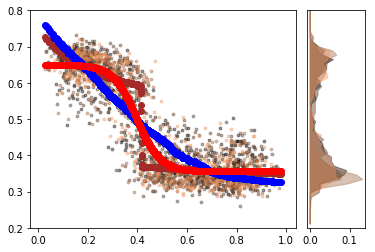

In [46]:
####CALCULATE ERROR AS A FUNCTION OF MORPH AND PLOT UNDER THESE PLOTS
f,ax = plot_LAR(LAR_rare,EM_rare,cmap='copper',ymin=.2,ymax=.8)
plot_theta = (logstim_2_morph(theta)+.3)/1.6
# print(mega_em_rare.shape,rare_cv[0].shape)
ax[0].scatter((mega_em_rare_n+.3)/1.6,rare_cv[0],color='brown')
# ax[0].scatter(plot_theta,rare_p_shat*rare_reg.coef_ + rare_reg.intercept_)
ax[0].scatter((mega_em_rare_n+.3)/1.6,rare_cv[1],color='blue')
# ax[0].scatter((mega_em_rare_n_ds+.3)/1.6,rare_cv[2],color='black')
# ax[0].scatter(mega_em_rare,sigmoid(mega_em_rare_n,rare_sigres.x))
ax[0].scatter((mega_em_rare_n+.3)/1.6,rare_cv[3],color='red')





f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\rare_sf_MAP_regression.pdf",format='pdf')




In [ ]:
abserr=np.abs(rare_cv[0]-mega_lar_rare)

[0.04090453 0.05147187 0.0613066  0.04215838]
[0.03090401 0.0301239  0.02943158 0.02839811]


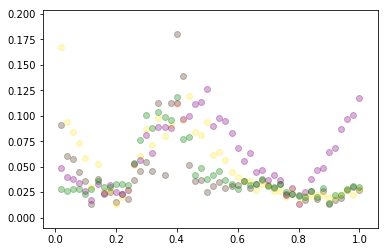

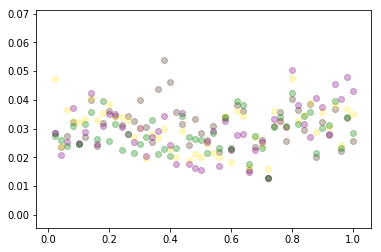

In [213]:
# bin mega_em_*

def err_density(mega_em,mega_lar):

    em_bins = np.linspace(0,1,num=51)
    em_rare_dig = np.digitize(mega_em,em_bins)

    reg_dense = np.zeros([4,em_bins.shape[0]-1])
    centers = (em_bins[:-1]+em_bins[1:])/2. 
   
    for i, (_center) in enumerate(centers.tolist()):

    #    find em inds
        mask = em_rare_dig==i

        if mask.sum()>0:
        #   find sf inds
            _sf = mega_lar[mask]

        #   leave bin out, and run regression
            _rreg = hreg()
            _rreg.fit(rare_map_spline(mega_em[~mask,np.newaxis]),mega_lar[~mask])
            _r_yhat  = _rreg.predict(rare_map_spline(np.array(_center).reshape([1,-1])*1.6-.3))

            _freg = hreg()
            _freg.fit(fam_map_spline(mega_em[~mask,np.newaxis]),mega_lar[~mask])
            _f_yhat  = _freg.predict(fam_map_spline(np.array(_center).reshape([1,-1])*1.6-.3))

            _lreg = hreg()
            _lreg.fit(mega_em[~mask,np.newaxis],mega_lar[~mask])
            _l_yhat  = _lreg.predict(np.array(_center).reshape([1,-1])*1.6-.3)

            _s_reg = least_squares(residuals,np.random.rand(4),args=(mega_em,mega_lar),loss='huber')
            _s_yhat = sigmoid(_center,_s_reg.x)

        #   find radius of sf needed to capture half the data
   
            reg_dense[0,i]= np.percentile(np.abs(_sf-_r_yhat),50)
            reg_dense[1,i]= np.percentile(np.abs(_sf-_f_yhat),50)
            reg_dense[2,i]= np.percentile(np.abs(_sf-_l_yhat),50)
            reg_dense[3,i]= np.percentile(np.abs(_sf-_s_yhat),50)
        else:
            for j in range(4):
                reg_dense[j,i]=np.nan
    return reg_dense,em_bins

# plot for different 

rare_reg_dense,em_bins = err_density(mega_em_rare_n,mega_lar_rare)
f,ax = plt.subplots()
ax.scatter(em_bins[1:],rare_reg_dense[0,:],color=plt.cm.copper(0.25),alpha=.3)
ax.scatter(em_bins[1:],rare_reg_dense[1,:],color=plt.cm.cividis(1.),alpha=.3)
ax.scatter(em_bins[1:],rare_reg_dense[2,:],color='purple',alpha=.3)
ax.scatter(em_bins[1:],rare_reg_dense[3,:],color='green',alpha=.3)

print(np.mean(rare_reg_dense,axis=1))

fam_reg_dense,em_bins = err_density(mega_em_fam_n,mega_lar_fam)
f,ax = plt.subplots()
ax.scatter(em_bins[1:],fam_reg_dense[0,:],color=plt.cm.copper(0.25),alpha=.3)
ax.scatter(em_bins[1:],fam_reg_dense[1,:],color=plt.cm.cividis(1.),alpha=.3)
ax.scatter(em_bins[1:],fam_reg_dense[2,:],color='purple',alpha=.3)
ax.scatter(em_bins[1:],fam_reg_dense[3,:],color='green',alpha=.3)
print(np.mean(fam_reg_dense,axis=1))

5
4222153.1
(281,)
4222153.2
(425,)
4222153.3
(90,)
4222174.1
(400,)
4222154.1
(510,)


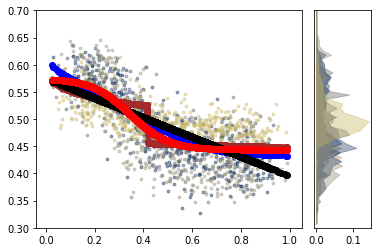

In [95]:
f,ax = plot_LAR(LAR_fam,EM_fam,cmap='cividis',ymin=.3,ymax=.7)
ax[0].scatter(mega_em_fam,fam_cv[0],color='brown')
ax[0].scatter(mega_em_fam,fam_cv[1],color='blue')
# ax[0].scatter(plot_theta,fam_reg.coef_*fam_p_shat+fam_reg.intercept_)
ax[0].scatter(mega_em_fam,fam_cv[2],color='black')
ax[0].scatter(mega_em_fam,fam_cv[3],color='red')

f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\fam_sf_MAP_regression.pdf",format='pdf')

# mask = (mega_em_fam>.25) & (mega_em_fam<.75)
# print(np.mean((fam_cv[0][mask]-mega_lar_fam[mask])**2))
# print(np.mean((fam_cv[1][mask]-mega_lar_fam[mask])**2))
# print(np.mean((fam_cv[2][mask]-mega_lar_fam[mask])**2))
# print(np.mean((fam_cv[3][mask]-mega_lar_fam[mask])**2))


# print(np.mean(fam_cv_err[3]**2))

In [44]:
# compare curve fits

# 10 fold cross -validation

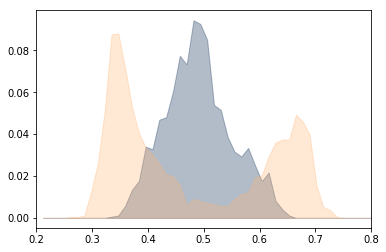

In [215]:
f,ax = plt.subplots()
bins = np.linspace(0.2,.8)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare_ds,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
ax.set_xlim([0.2,.8])
f.savefig(os.path.join(basedir,'sf_hist.pdf'),format='pdf')

In [216]:
D,p = sp.stats.ks_2samp(mega_lar_rare_ds,mega_lar_fam)
print(D,p)

0.4003119927272041 8.210828346969904e-133


In [217]:
morph_bins = np.linspace(0,1,num=51)
mega_em_rare_bin = np.digitize(mega_em_rare,morph_bins,right=True)
mega_em_fam_bin = np.digitize(mega_em_fam,morph_bins,right=True)

em_ = morph_bins[1:]
rare_,rare_sig = np.zeros([50,]),np.zeros([50,])

fam_,fam_sig = np.zeros([50,]), np.zeros([50,])
for j in range(50):
    r_mask = mega_em_rare_bin==j
    if r_mask.sum()>0:
        rare_[j]= np.nanmean(mega_lar_rare[r_mask])
        rare_sig[j]=sp.stats.iqr(mega_lar_rare[r_mask])
    else:
        rare_[j]=np.nan
        rare_sig[j]=np.nan
    
    f_mask = mega_em_fam_bin==j
    if f_mask.sum()>0:
        fam_[j]= np.nanmedian(mega_lar_fam[f_mask])
        fam_sig[j]=sp.stats.iqr(mega_lar_fam[f_mask])
    else:
        fam_[j]=np.nan
        fam_sig[j]=np.nan

        

        

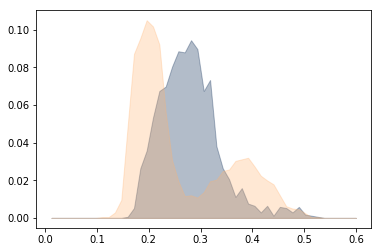

In [218]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s0_fam,bins)
rare_hist,edges = np.histogram(mega_s0_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

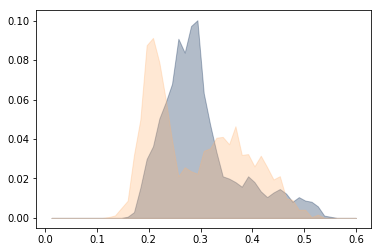

In [219]:
f,ax = plt.subplots()
bins = np.linspace(0,.6)
fam_hist,edges = np.histogram(mega_s1_fam,bins)
rare_hist,edges = np.histogram(mega_s1_rare,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

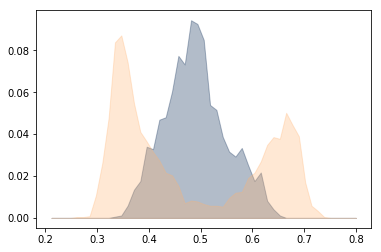

In [220]:
# plot distributions of absolute values and cdfs 
f,ax = plt.subplots()
bins = np.linspace(0.2,.8)
fam_hist,edges = np.histogram(np.abs(mega_lar_fam),bins)
rare_hist,edges = np.histogram(np.abs(mega_lar_rare),bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))

# f.savefig(os.path.join(basedir,'abs_lsr_hist.pdf'),format='pdf')

(49,)


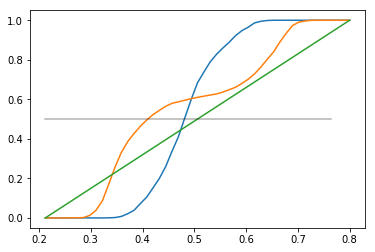

In [221]:
f,ax = plt.subplots()
print(fam_hist.shape)
fam_hist =fam_hist/fam_hist.sum()
rare_hist= rare_hist/rare_hist.sum()

ax.plot(bins[1:],np.cumsum(fam_hist))
ax.plot(bins[1:],np.cumsum(rare_hist))
ax.plot(bins[1:],np.linspace(0,1,num=bins[1:].shape[0]))
ax.plot(bins[1::5],.5*np.ones([10,]),alpha=.3,color='black')
# f.savefig(os.path.join(basedir,'abs_lsr_cdf.pdf'),format='pdf')


In [222]:
U,p = sp.stats.mannwhitneyu(np.abs(mega_lar_rare),np.abs(mega_lar_fam))
print(U,p)

1715954.0 7.362054050071875e-20


In [223]:
basedir = "G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures"

# LAR over sessions within mouse

In [224]:
def _plot_LAR_session(lar,em,color='red',ymin=.2,ymax=.8,f=None,gs=None,ax_scat = None,ax_hist=None):
    
    if f is None:
        f = plt.figure()
        gs = gridspec.GridSpec(1,5)
        ax_scat = f.add_subplot(gs[:,:4])
        ax_hist = f.add_subplot(gs[:,-1])
    
   
    bins = np.linspace(ymin,ymax,num=20)
    ax_scat.scatter(em,lar,color=color,alpha=.6,s=8)
    hist,edges = np.histogram(lar,bins=bins)
    ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=color,alpha=.4)
#     ax_hist.hist(lar,bins=50,orientation='horizontal',color=color,alpha=.4,density=True)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return {'f':f,'ax_scat':ax_scat,'gs':gs,'ax_hist':ax_hist}

In [251]:

mouse = '4222168.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
2490,4222168.1,25_08_2019,3,TwoTower_foraging,48,1,CA1,2019-08-25,G:\My Drive\VR_Data\TwoTower\4222168.1\25_08_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\25_08_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\25_08_2...
2521,4222168.1,28_08_2019,2,TwoTower_foraging,80,1,CA1,2019-08-28,G:\My Drive\VR_Data\TwoTower\4222168.1\28_08_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\28_08_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\28_08_2...
2540,4222168.1,30_08_2019,3,TwoTower_foraging,37,1,CA1,2019-08-30,G:\My Drive\VR_Data\TwoTower\4222168.1\30_08_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\30_08_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\30_08_2...
2549,4222168.1,02_09_2019,3,TwoTower_foraging,55,1,CA1,2019-09-02,G:\My Drive\VR_Data\TwoTower\4222168.1\02_09_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\02_09_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\02_09_2...
2558,4222168.1,03_09_2019,4,TwoTower_foraging,100,1,CA1,2019-09-03,G:\My Drive\VR_Data\TwoTower\4222168.1\03_09_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\03_09_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\03_09_2...
2574,4222168.1,04_09_2019,3,TwoTower_foraging,93,1,CA1,2019-09-04,G:\My Drive\VR_Data\TwoTower\4222168.1\04_09_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\04_09_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\04_09_2...
2585,4222168.1,05_09_2019,2,TwoTower_foraging,89,1,CA1,2019-09-05,G:\My Drive\VR_Data\TwoTower\4222168.1\05_09_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\05_09_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\05_09_2...
2592,4222168.1,06_09_2019,3,TwoTower_foraging,95,1,CA1,2019-09-06,G:\My Drive\VR_Data\TwoTower\4222168.1\06_09_2...,None,G:\My Drive\2P_Data\TwoTower\4222168.1\06_09_2...,G:\My Drive\2P_Data\TwoTower\4222168.1\06_09_2...


In [252]:
sess = df_mouse.iloc[0]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)


ds_mask = make_ds_mask(_em)
_em_ds, _lar_ds = _em[ds_mask],_lar[ds_mask]

# ed = err_density(_lar,_em)
print('Rare r2:', 1-((loo_reg(rare_map_spline(_em*1.6-.3),_lar,model=linreg())-_lar)**2).mean()/np.var(_lar))
print('Fam r2:', 1-((loo_reg(fam_map_spline(_em*1.6-.3),_lar,model=linreg())-_lar)**2).mean()/np.var(_lar))

# print('Rare BIC', BIC(loo_reg(rare_map_spline(_em*1.6-.3),_lar),_lar,2))
# print('Freq BIC', BIC(loo_reg(fam_map_spline(_em*1.6-.3),_lar),_lar,2))

num aberrant ttls 0.0
32720 (32720,) (32720, 21) 93202
(93202,) (93202, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(32720, 922)
[ 4 19 13 22  2]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
13.0
[1 2 3 4 5]
Rare r2: 0.8616491415281391
Fam r2: 0.8404623520458732


0
0.06437601875 0.9400115625
[23 15 17 15 20]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
17.0
[1 2 3 4 5]
Rare r2: 0.7291185029509443
Fam r2: 0.7061894977136562
1
0.06707624374999999 0.9773127500000001
[30 14 14 19 23]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
19.0
[1 2 3 4 5]
Rare r2: 0.9224814550827567
Fam r2: 0.8361117887462943
2
0.08743915624999998 0.9159669693750001
[23 20 16 16 25]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
20.0
[1 2 3 4 5]
Rare r2: 0.8113830730297791
Fam r2: 0.7547635501399521
3
0.07407391249999999 0.9021447812500001
[26 15 18 15 26]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
18.0
[1 2 3 4 5]
Rare r2: 0.7823829324733484
Fam r2: 0.8066861208970305
4
0.09994564374999998 0.9134122687500001
[26 18 14 17 25]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
18.0
[1 2 3 4 5]
Rare r2: 0.7757776255137563
Fam r2: 0.7585126019183345


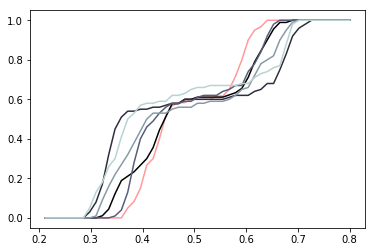

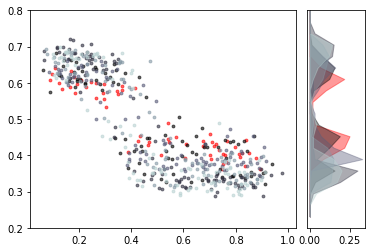

In [253]:
edges = np.linspace(.2,.8)


f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red',alpha=.4)

fig_d = _plot_LAR_session(_lar,_em,color='red')
# fig_d['ax_scat'].scatter(_em,loo_reg(rare_map_spline(_em*1.6-.3),_lar),color='red')

N = len(LAR_rare[mouse])
for sess, (lar,em) in enumerate(zip(LAR_rare[mouse],EM_rare[mouse])):
    print(sess)
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N),ymin=.2,ymax=.8)
    print(em.min(),em.max())
    ds_mask = make_ds_mask(em*1.6-.3)
    em_ds,lar_ds = em[ds_mask]*1.6-.3,lar[ds_mask]
    print('Rare r2:', 1-((loo_reg(rare_map_spline(em),lar)-lar)**2).mean()/np.var(lar))
    
#     fig_d['ax_scat'].scatter(em,loo_reg(rare_map_spline(em*1.6-.3),lar),color=plt.cm.bone(np.float(sess)/N))
    
    print('Fam r2:', 1-((loo_reg(fam_map_spline(em),lar)-lar)**2).mean()/np.var(lar))
#     fig_d['ax_scat'].scatter(em,loo_reg(fam_map_spline(em*1.4-.2),lar),color=plt.cm.cividis(np.float(sess)/N))
#     print(model_r2(em,lar))
#     _reg_dense,em_bins = err_density(em,lar)
#     print(np.nanmean(_reg_dense,axis=1))
   
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

In [254]:
em_mouse,lar_mouse = [],[]
for (e,l) in zip(EM_rare[mouse],LAR_rare[mouse]):
    em_mouse.extend(e.tolist())
    lar_mouse.extend(l.tolist())
em_mouse = np.array(em_mouse)*1.4-.2
lar_mouse = np.array(lar_mouse)


ds_mask = make_ds_mask(em_mouse)        
em_mouse_ds, lar_mouse_ds = em_mouse[ds_mask],lar_mouse[ds_mask]

print('Rare r2:', 1-((loo_reg(rare_map_spline(em_mouse),lar_mouse,model=linreg())-lar_mouse)**2).mean()/np.var(lar_mouse))
print('Fam r2:', 1-((loo_reg(fam_map_spline(em_mouse),lar_mouse,model=linreg())-lar_mouse)**2).mean()/np.var(lar_mouse))

[112  93  89 103  93]
[-0.3    0.125  0.375  0.625  0.875  1.3  ]
93.0
[1 2 3 4 5]
Rare r2: 0.8007678552217125
Fam r2: 0.7805651804282229


In [268]:
mouse = '4222154.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1717,4222154.1,08_04_2019,1,TwoTower_foraging,120,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222154.1\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\08_04_2...
1741,4222154.1,10_04_2019,4,TwoTower_foraging,120,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222154.1\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\10_04_2...
1762,4222154.1,12_04_2019,2,TwoTower_foraging,95,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222154.1\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\12_04_2...
1782,4222154.1,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222154.1\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\14_04_2...
1797,4222154.1,15_04_2019,2,TwoTower_foraging,102,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222154.1\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\15_04_2...
1810,4222154.1,16_04_2019,2,TwoTower_foraging,71,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222154.1\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\16_04_2...
1819,4222154.1,17_04_2019,2,TwoTower_foraging,78,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222154.1\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\17_04_2...
1828,4222154.1,18_04_2019,2,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222154.1\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\18_04_2...
1836,4222154.1,19_04_2019,2,TwoTower_foraging,79,1,CA1,2019-04-19,G:\My Drive\VR_Data\TwoTower\4222154.1\19_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222154.1\19_04_2...,G:\My Drive\2P_Data\TwoTower\4222154.1\19_04_2...


In [269]:
sess = df_mouse.iloc[1]
_lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)

print('Rare r2:', 1-((loo_reg(rare_map_spline(_em*1.6-.3),_lar,model=linreg())-_lar)**2).mean()/np.var(_lar))
print('Fam r2:', 1-((loo_reg(fam_map_spline(_em*1.6-.3),_lar,model=linreg())-_lar)**2).mean()/np.var(_lar))

num aberrant ttls 0.0
26012 (26012,) (26012, 21) 85076
(85076,) (85076, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
(26012, 591)
Rare r2: 0.5270471632450666
Fam r2: 0.591311024720585


0
Rare r2: 0.16047629997876534
Fam r2: 0.2219660732209917
1
Rare r2: 0.3848261256574259
Fam r2: 0.4670983546531101
2
Rare r2: 0.37461223067296634
Fam r2: 0.40522221324770846
3
Rare r2: 0.25222748885586677
Fam r2: 0.2844626098120888
4
Rare r2: 0.3830804939335348
Fam r2: 0.4024579444155544


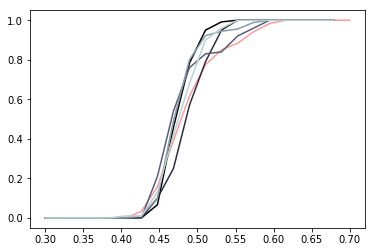

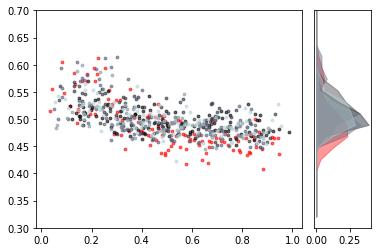

In [270]:
edges = np.linspace(0.30,.7,num=20)



f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red',alpha=.4)

fig_d = _plot_LAR_session(_lar,_em,color='red',ymin=.3,ymax=.7)

N = len(LAR_fam[mouse])
for sess, (lar,em) in enumerate(zip(LAR_fam[mouse],EM_fam[mouse])):
    print(sess)
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[0:-1],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N),ymin=.3,ymax=.7)
    
    print('Rare r2:', 1-((loo_reg(rare_map_spline(em*1.6-.3),lar,model=linreg())-lar)**2).mean()/np.var(lar))
    
#     fig_d['ax_scat'].scatter(em,loo_reg(rare_map_spline(em*1.4-.2),lar),color=plt.cm.bone(np.float(sess)/N))
    
    print('Fam r2:', 1-((loo_reg(fam_map_spline(em*1.6-.3),lar,model=linreg())-lar)**2).mean()/np.var(lar))
#     fig_d['ax_scat'].scatter(em,loo_reg(fam_map_spline(em*1.6-.3),lar),color=plt.cm.bone(np.float(sess)/N))
    
    
f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

In [271]:
em_mouse,lar_mouse = [],[]
for (e,l) in zip(EM_fam[mouse],LAR_fam[mouse]):
    em_mouse.extend(e.tolist())
    lar_mouse.extend(l.tolist())
em_mouse = np.array(em_mouse)*1.6-.3
lar_mouse = np.array(lar_mouse)


print('Rare r2:', 1-((loo_reg(rare_map_spline(em_mouse),lar_mouse,model=linreg())-lar_mouse)**2).mean()/np.var(lar_mouse))
print('Fam r2:', 1-((loo_reg(fam_map_spline(em_mouse),lar_mouse,model=linreg())-lar_mouse)**2).mean()/np.var(lar_mouse))

Rare r2: 0.31443485595102383
Fam r2: 0.35713139584810505


In [ ]:
edges = np.linspace(0,1)



f_cdf,ax_cdf = plt.subplots()

hist,trsh = np.histogram(_lar,edges)
hist = hist/hist.sum()
ax_cdf.plot(edges[1:],np.cumsum(hist),color='red')

fig_d = _plot_LAR_session(_lar,_em,color='red')

N = len(LAR_dg[mouse])
for sess, (lar,em) in enumerate(zip(LAR_dg[mouse],EM_dg[mouse])):
    hist,trsh = np.histogram(lar,edges)
    hist=hist/hist.sum()
    ax_cdf.plot(edges[1:],np.cumsum(hist),color=plt.cm.bone(np.float(sess)/N))
    fig_d = _plot_LAR_session(lar,em,**fig_d,color=plt.cm.bone(np.float(sess)/N),ymin=-.15,ymax=.15)
    
ax_cdf.set_xlim([-.2,.2])
# f_cdf.savefig(os.path.join(basedir,"%s_sess_lsr_cdf.pdf" % mouse),format='pdf')
# fig_d['f'].savefig(os.path.join(basedir,"%s_sess_lsr.pdf" % mouse), format = 'pdf')

num aberrant ttls 0.0
22392 (22392,) (22392, 21) 74301
(74301,) (74301, 21)
frame diff 0
(22392, 1973)
num aberrant ttls 0.0
13506 (13506,) (13506, 21) 45655
(45655,) (45655, 21)
frame diff 0
(13506, 1178)
num aberrant ttls 0.0
19948 (19948,) (19948, 21) 65960
(65960,) (65960, 21)
frame diff 0
(19948, 996)
num aberrant ttls 0.0
21698 (21698,) (21698, 21) 60178
(60178,) (60178, 21)
frame diff 0
(21698, 1237)


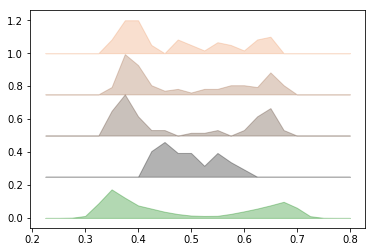

In [55]:
f,ax = plt.subplots()
bins = np.linspace(.2,.8,num=25)
rare_hist,edges = np.histogram(mega_lar_rare,bins)

ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color='green')

N =4
for i,mouse in enumerate(morph_rare):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    if mouse == '4139268.1':
        sess = df_mouse.iloc[1]
    else:
        sess = df_mouse.iloc[2]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum() + (i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.copper(np.float(i/N)))
    
f.savefig(os.path.join(basedir,"sess3_v_latecomparison_rare.pdf"), format = 'pdf')

num aberrant ttls 0.0
one frame correction
31722 (31722,) (31722, 21) 103701
(103701,) (103701, 21)
frame diff 0
(31722, 475)
num aberrant ttls 0.0
35978 (35978,) (35978, 21) 119008
(119008,) (119008, 21)
frame diff 0
(35978, 2016)
num aberrant ttls 0.0
24296 (24296,) (24296, 21) 79674
(79674,) (79674, 21)
frame diff 0
(24296, 295)
num aberrant ttls 0.0
33583 (33583,) (33583, 21) 110386
(110386,) (110386, 21)
frame diff 0
(33583, 1965)
num aberrant ttls 0.0
26012 (26012,) (26012, 21) 85076
(85076,) (85076, 21)
frame diff 0
(26012, 591)


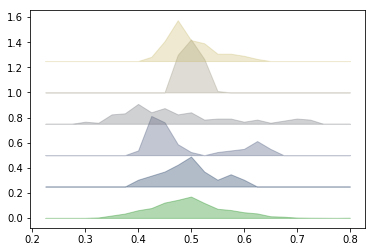

In [56]:
f,ax = plt.subplots()
bins = np.linspace(.2,.8,num=25)
fam_hist,edges = np.histogram(mega_lar_fam,bins)

ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color='green')

N =5
for i,mouse in enumerate(morph_familiar):
    df_mouse = df[df['MouseName'].str.match(mouse)]
    sess = df_mouse.iloc[1]
    _lar,_em,sim0,sim1 = sess_lar(sess,max_pos=450.)
    _hist,edges = np.histogram(_lar,bins)
    ax.fill_between(edges[1:],_hist/_hist.sum()+(i+1)/4,y2=(i+1)/4,alpha=.3,color=plt.cm.cividis(np.float(i/N)))

f.savefig(os.path.join(basedir,"sess3_v_latecomparison_fam.pdf"), format = 'pdf')

# comparison with familar morph with discrimination

In [45]:
LAR_fd,EM_fd,S0_fd,S1_fd = LAR_list_maker(['4222157.4','4222169.1','4222169.2','4222169.4'],firstSess=2)

session ind 2
num aberrant ttls 0.0
24514 (24514,) (24514, 21) 69410
(69410,) (69410, 21)
frame diff 0
(24514, 1491)


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:334: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])
C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:333: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])


session ind 3
num aberrant ttls 0.0
30893 (30893,) (30893, 21) 86929
(86929,) (86929, 21)
frame diff 0
(30893, 1428)
session ind 4
num aberrant ttls 0.0
26850 (26850,) (26850, 21) 75392
(75392,) (75392, 21)
frame diff 0
(26850, 1455)
session ind 5
num aberrant ttls 0.0
27977 (27977,) (27977, 21) 78367
(78367,) (78367, 21)
frame diff 0
(27977, 1371)
session ind 6
num aberrant ttls 0.0
30469 (30469,) (30469, 21) 85961
(85961,) (85961, 21)
frame diff 0
(30469, 1521)
session ind 7
num aberrant ttls 0.0
27484 (27484,) (27484, 21) 78628
(78628,) (78628, 21)
frame diff 0
(27484, 1367)
session ind 8
num aberrant ttls 0.0
24753 (24753,) (24753, 21) 71281
(71281,) (71281, 21)
frame diff 0
(24753, 1429)
session ind 9
num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
(63586,) (63586, 21)
frame diff 0
(22270, 1472)
session ind 10
num aberrant ttls 0.0
21653 (21653,) (21653, 21) 60130
(60130,) (60130, 21)
frame diff 0
(21653, 1537)
session ind 11
num aberrant ttls 0.0
25328 (25328,) (25328, 21)

4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)
4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


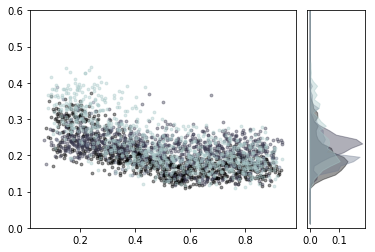

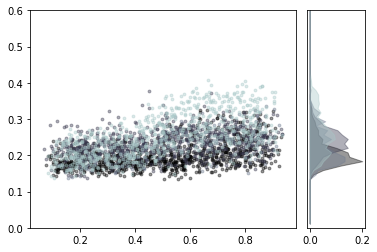

In [46]:
f,ax = plot_LAR(S0_fd,EM_fd,cmap='bone',ymin=0,ymax=.6)
# ax[0].set_ylim([0,.6])

f,ax = plot_LAR(S1_fd,EM_fd,cmap='bone',ymin=0,ymax=.6)
# ax[0].set_ylim([0,.6])

4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


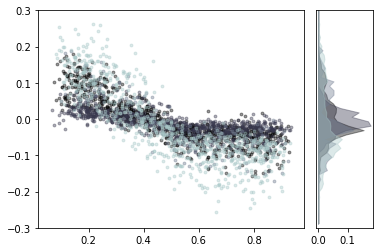

In [55]:
f,ax = plot_LAR(LAR_fd,EM_fd,cmap='bone',ymin=-.3,ymax=.3)
f.savefig(os.path.join(basedir,'fd_simratio.pdf'),format='pdf')



4
4222157.4
(1030,)
4222169.1
(797,)
4222169.2
(135,)
4222169.4
(800,)


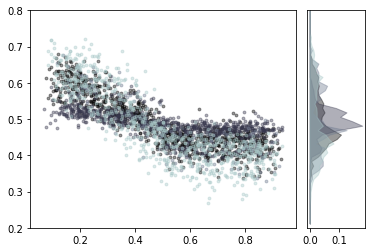

In [59]:
prob_fd = {}
for k in LAR_fd.keys():
    #if k != '4222154.1':
        prob_fd[k] = np.array(S0_fd[k])/(np.array(S0_fd[k])+np.array(S1_fd[k]))
        
f,ax = plot_LAR(prob_fd,EM_fd,cmap='bone',ymin=0.2,ymax=.8)

In [48]:
mega_lar_fd = mega_lar(LAR_fd)

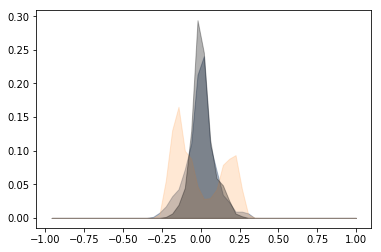

In [49]:
f,ax = plt.subplots()
bins = np.linspace(-1,1)
fam_hist,edges = np.histogram(mega_lar_fam,bins)
rare_hist,edges = np.histogram(mega_lar_rare,bins)
fd_hist,edges = np.histogram(mega_lar_fd,bins)
ax.fill_between(edges[1:],fam_hist/fam_hist.sum(),alpha=.3,color=plt.cm.cividis(0.))
ax.fill_between(edges[1:],rare_hist/rare_hist.sum(),alpha=.3,color=plt.cm.copper(.9))
ax.fill_between(edges[1:],fd_hist/fd_hist.sum(),alpha=.3,color=plt.cm.bone(0.))
f.savefig(os.path.join(basedir,'lsr_hist_fd.pdf'),format='pdf')

In [50]:
LAR_rd,EM_rd,S0_rd,S1_rd = LAR_list_maker(['4139224.2','4139224.3','4139224.5','4139219.1','4139219.3'],firstSess=5)

session ind 5
num aberrant ttls 0.0
26741 (26741,) (26741, 20) 83632
(83632,) (83632, 20)
frame diff 0
(26741, 1987)
session ind 6
num aberrant ttls 0.0
23611 (23611,) (23611, 20) 75002
(75002,) (75002, 20)
frame diff 0
(23611, 2069)
session ind 7
num aberrant ttls 0.0
28600 (28600,) (28600, 20) 90254
(90254,) (90254, 20)
frame diff 0
(28600, 1982)
session ind 8
num aberrant ttls 0.0
24063 (24063,) (24063, 20) 76746
(76746,) (76746, 20)
frame diff 0
(24063, 1837)
session ind 9
num aberrant ttls 0.0
27943 (27943,) (27943, 20) 90302
(90302,) (90302, 20)
frame diff 0
(27943, 1884)
session ind 5
num aberrant ttls 0.0
31376 (31376,) (31376, 20) 99274
(99274,) (99274, 20)
frame diff 0
(31376, 2100)
session ind 6
num aberrant ttls 0.0
29572 (29572,) (29572, 20) 92598
(92598,) (92598, 20)
frame diff 0
(29572, 1980)
session ind 7
num aberrant ttls 0.0
37977 (37977,) (37977, 20) 121175
(121175,) (121175, 20)
frame diff 0
(37977, 2009)
session ind 8
num aberrant ttls 0.0
32188 (32188,) (32188, 20

3
4139224.2
(449,)
4139224.3
(540,)
4139224.5
(623,)


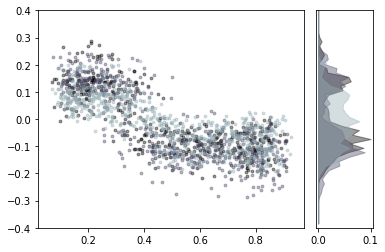

In [57]:
f,ax = plot_LAR(LAR_rd,EM_rd,cmap='bone',ymin=-.4,ymax=.4)

3
4139224.2
(449,)
4139224.3
(540,)
4139224.5
(623,)


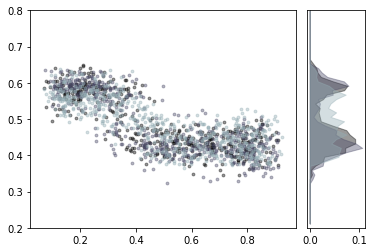

In [60]:
prob_rd = {}
for k in LAR_rd.keys():
    #if k != '4222154.1':
        prob_rd[k] = np.array(S0_rd[k])/(np.array(S0_rd[k])+np.array(S1_rd[k]))
        
f,ax = plot_LAR(prob_rd,EM_rd,cmap='bone',ymin=.2,ymax=.8)

In [52]:
LAR_dg, EM_dg, S0_df, S1_df = LAR_list_maker(['4222193.3'],firstSess=4)

session ind 4
num aberrant ttls 0.0
17258 (17258,) (17258, 21) 45680
(45680,) (45680, 21)
frame diff 0
(17258, 217)


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:122: RuntimeWarning: invalid value encountered in true_divide
  return frmap, occupancy/occupancy.ravel().sum()
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


session ind 5
num aberrant ttls 0.0
25985 (25985,) (25985, 21) 70127
(70127,) (70127, 21)
frame diff 0
(25985, 390)
session ind 6
num aberrant ttls 0.0
28101 (28101,) (28101, 21) 76551
(76551,) (76551, 21)
frame diff 0
(28101, 476)
session ind 7
num aberrant ttls 0.0
21828 (21828,) (21828, 21) 58775
(58775,) (58775, 21)
frame diff 0
(21828, 302)
session ind 8
num aberrant ttls 0.0
23445 (23445,) (23445, 21) 62964
(62964,) (62964, 21)
frame diff 0
(23445, 436)
session ind 9
num aberrant ttls 0.0
25905 (25905,) (25905, 21) 70033
(70033,) (70033, 21)
frame diff 0
(25905, 367)


1
4222193.3
(595,)


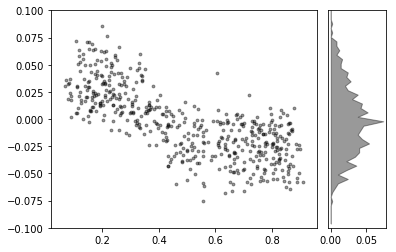

In [53]:
f,ax = plot_LAR(LAR_dg,EM_dg,cmap='bone',ymin=-.1,ymax=.1)